[Reference](https://medium.com/mlearning-ai/data-science-basics-time-series-analysis-with-oil-price-data-in-python-6f0b58321659)

In [2]:
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from scipy import stats
import statsmodels.api as sm
import seaborn as sns

data_dir = "./data/oil_price_analysis"
os.makedirs(data_dir, exist_ok=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Crude Oil Prices: West Texas Intermediate (WTI) — Cushing, Oklahoma (DCOILWTICO)

In [3]:
start = dt.datetime(1950, 1, 1)
end = dt.datetime(2022, 5, 21)
wti_oil_price = web.DataReader('DCOILWTICO', 'fred', start, end)
# save the data
file_path = f"{data_dir}/DCOILWTICO.csv"
wti_oil_price.to_csv(file_path)
wti_oil_price

,DCOILWTICO
DATE,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87
...,...
2022-05-16,114.07
2022-05-17,112.31
2022-05-18,109.67


In [4]:
wti_oil_price = pd.read_csv(file_path, index_col="DATE", parse_dates=True)
print(wti_oil_price.shape)
wti_oil_price.tail(3)
wti_oil_price

(9492, 1)


,DCOILWTICO
DATE,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87
...,...
2022-05-16,114.07
2022-05-17,112.31
2022-05-18,109.67


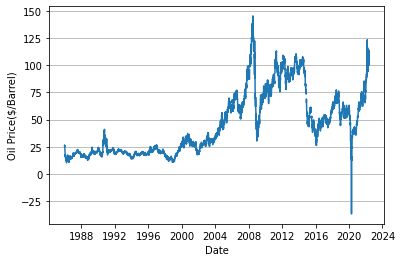

In [5]:
plt.plot(wti_oil_price)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Oil Price($/Barrel)")
plt.show()

In [6]:
wti_oil_price.loc['2020-04-20']

DCOILWTICO   -36.98
Name: 2020-04-20 00:00:00, dtype: float64

In [7]:
wti_oil_price.loc['2020-04-20':'2020-04-30']

,DCOILWTICO
DATE,
2020-04-20,-36.98
2020-04-21,8.91
2020-04-22,13.64
2020-04-23,15.06
2020-04-24,15.99
2020-04-27,12.17
2020-04-28,12.40
2020-04-29,15.04
2020-04-30,19.23


In [8]:
wti_oil_price.loc[dt.datetime(2020, 4, 20)]

DCOILWTICO   -36.98
Name: 2020-04-20 00:00:00, dtype: float64

In [9]:
wti_oil_price.loc['2020-04']
wti_oil_price.loc['2020']

,DCOILWTICO
DATE,
2020-01-01,NaN
2020-01-02,61.17
2020-01-03,63.00
2020-01-06,63.27
2020-01-07,62.70
...,...
2020-12-25,NaN
2020-12-28,47.50
2020-12-29,47.85


# Crude Oil Prices: Brent — Europe (DCOILBRENTEU)

In [10]:
start = dt.datetime(1950, 1, 1)
end = dt.datetime(2022, 5, 21)
brent_oil_price = web.DataReader('DCOILBRENTEU', 'fred', start, end)
# save the data
file_path = f"{data_dir}/DCOILBRENTEU.csv"
brent_oil_price.to_csv(file_path)
brent_oil_price = pd.read_csv(file_path, index_col="DATE", parse_dates=True)
print(brent_oil_price.shape)
brent_oil_price.tail(3)
brent_oil_price

(9133, 1)


,DCOILBRENTEU
DATE,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2022-05-16,114.86
2022-05-17,112.89
2022-05-18,110.04


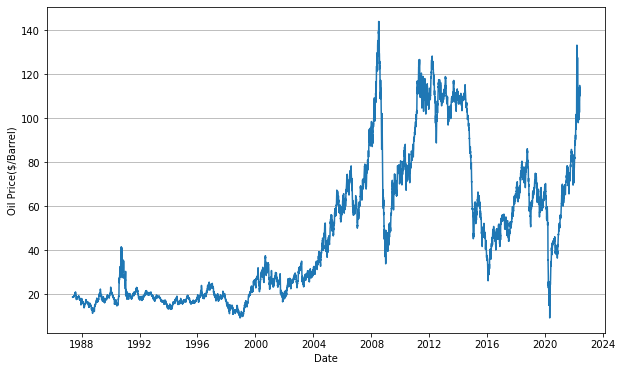

In [11]:
brent_oil_price = brent_oil_price.dropna()

plt.figure(figsize=(10, 6))
plt.plot(brent_oil_price)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Oil Price($/Barrel)")
plt.show()

## Resampling

In [12]:
monthly_data_list = []
year_list = brent_oil_price.index.year.unique()
month_list = sorted(brent_oil_price.index.month.unique())

for year in year_list:
    for month in month_list:
        last_day_data = brent_oil_price[(brent_oil_price.index.year == year) & (brent_oil_price.index.month == month)].tail(1)
        monthly_data_list.append(last_day_data)
brent_oil_price_monthly = pd.concat(monthly_data_list)
brent_oil_price_monthly.index = pd.to_datetime(
    brent_oil_price_monthly.index.strftime("%Y-%m"))  # reset index to YYYY-01-01
brent_oil_price_monthly.tail()

,DCOILBRENTEU
DATE,
2022-01-01,92.35
2022-02-01,103.08
2022-03-01,107.29
2022-04-01,108.36
2022-05-01,113.63


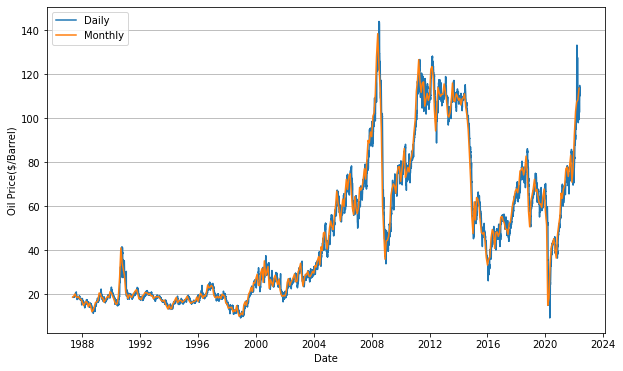

In [13]:
plt.figure(figsize=(10,6))
plt.plot(brent_oil_price, label="Daily")
plt.plot(brent_oil_price_monthly ,label="Monthly")
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Oil Price($/Barrel)")
plt.legend(loc="upper left")
plt.show()

## Moving Average

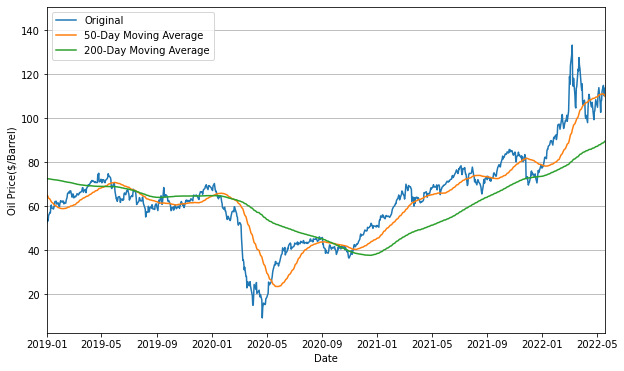

In [15]:
# moving average
brent_oil_price_moving_average_50 = brent_oil_price.rolling(50).mean()
brent_oil_price_moving_average_200 = brent_oil_price.rolling(200).mean()

plt.figure(figsize=(10,6))
plt.plot(brent_oil_price, label="Original")
plt.plot(brent_oil_price_moving_average_50, label="50-Day Moving Average")
plt.plot(brent_oil_price_moving_average_200, label="200-Day Moving Average")
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Oil Price($/Barrel)")
plt.legend(loc="upper left")
plt.xlim((dt.datetime(2019, 1, 1), max(brent_oil_price.index)))
plt.show()

## Differencing

In [16]:
brent_oil_price_diff = brent_oil_price_monthly - brent_oil_price_monthly.shift()
brent_oil_price_diff.head()

,DCOILBRENTEU
DATE,
1987-05-01,NaN
1987-06-01,0.50
1987-07-01,0.95
1987-08-01,-1.40
1987-09-01,-0.15


In [17]:
brent_oil_price_monthly.diff().head()

,DCOILBRENTEU
DATE,
1987-05-01,NaN
1987-06-01,0.50
1987-07-01,0.95
1987-08-01,-1.40
1987-09-01,-0.15


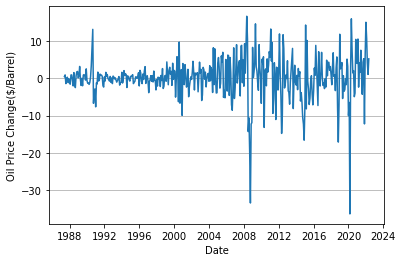

In [18]:
plt.plot(brent_oil_price_diff)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Oil Price Change($/Barrel)")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


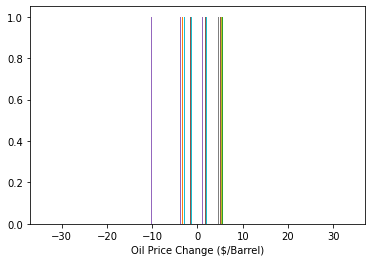

In [19]:
plt.hist(brent_oil_price_diff, bins=20)
plt.xlabel("Oil Price Change ($/Barrel)")
plt.xlim(-37, 37)
plt.show()

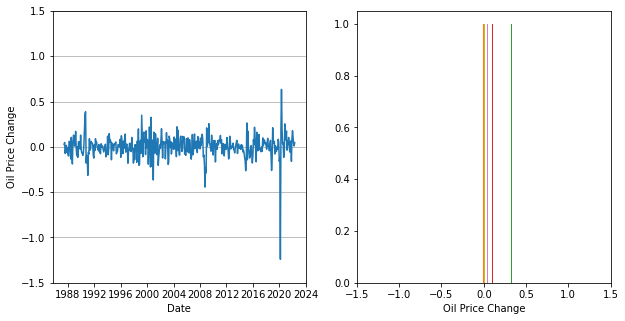

In [20]:
brent_oil_price_logdiff = np.log(brent_oil_price_monthly) - np.log(brent_oil_price_monthly.shift())

fig, axes = plt.subplots(ncols=2, figsize=(10,5))
axes[0].plot(brent_oil_price_logdiff.dropna())
axes[0].grid(axis="y")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Oil Price Change")
axes[0].set_ylim(-1.5, 1.5)

axes[1].hist(brent_oil_price_logdiff.dropna(), bins=20)
axes[1].set_xlabel("Oil Price Change")
axes[1].set_xlim(-1.5, 1.5)

plt.show()

## Autocorrelation

In [21]:
# autocorrelation
acf = sm.tsa.stattools.acf(brent_oil_price_monthly, nlags=20)
acf

# partial autocorrelation
pacf = sm.tsa.stattools.pacf(brent_oil_price_monthly, nlags=20, method='ols')
pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


array([ 1.        ,  0.98949037, -0.25377752,  0.030118  ,  0.01713665,
        0.0583729 ,  0.03189995,  0.02184152,  0.03315795,  0.01693411,
        0.02106662, -0.01482712, -0.06966245,  0.04062062,  0.05176052,
        0.0349034 , -0.05176923, -0.01608904,  0.03430102,  0.03284289,
       -0.00695002])

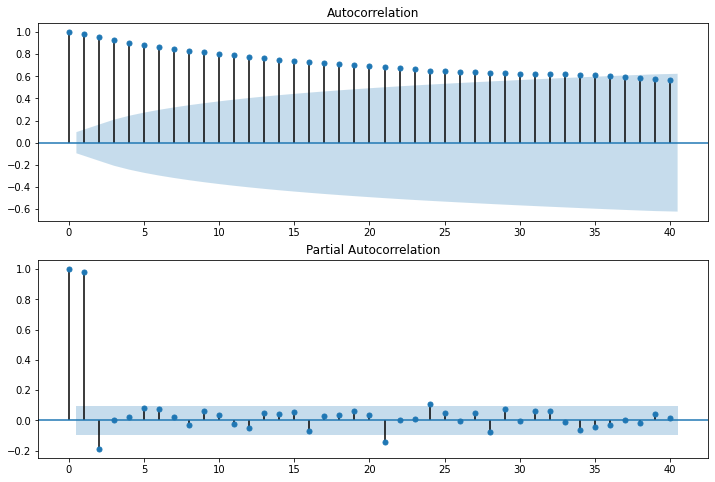

In [22]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(brent_oil_price_monthly, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(brent_oil_price_monthly, lags=40, ax=ax2)

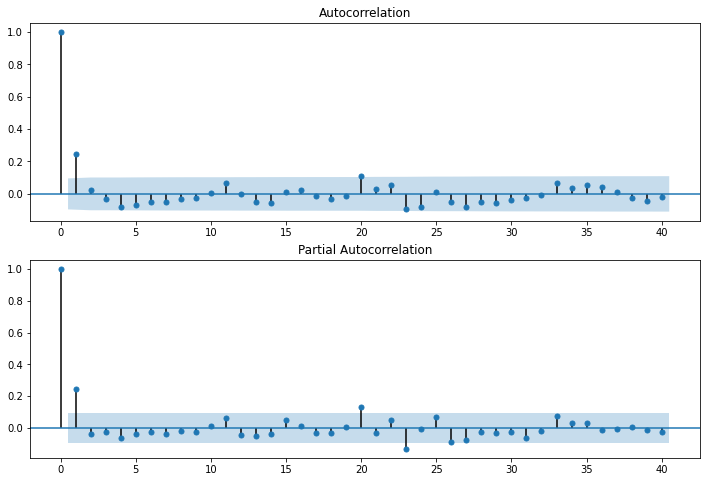

In [23]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(brent_oil_price_diff.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(brent_oil_price_diff.dropna(), lags=40, ax=ax2)